## LOWESS to extract a trend from a time series.

LOWESS (Locally Weighted Scatterplot Smoothing) is a popular tool used in regression analysis that creates a smooth line through a timeplot or scatter plot to help you to see relationship between variables and foresee trends.
### Uses
* Fitting a line to a scatter plot or time plot where noisy data values, sparse data points or weak interrelationships interfere with your ability to see a line of best fit.
* Linear regression where least squares fitting doesn’t create a line of good fit or is too labor-intensive to use.

### Parametric and Non-Parametric Fitting
LOWESS, and least squares fitting in general, are non-parametric strategies for fitting a smooth curve to data points. 

* `“Parametric”` means that the researcher or analyst assumes in advance that the data fits some type of distribution (i.e. the normal distribution). 

* Because some type of distribution is assumed in advance, parametric fitting can lead to fitting a smooth curve that misrepresents the data. 

* In those cases, non-parametric smoothers may be a better choice. Non-parametric smoothers like LOESS try to find a curve of best fit without assuming the data must fit some distribution shape. 

* In general, both types of smoothers are used for the same set of data to offset the advantages and disadvantages of each type of smoother.


### LOWESS (Locally Weighted Scatterplot Smoothing)
* LOWESS curve at 𝑥 is given by the weighted robust linear regression
* Fit a weighted robust linear regression to a subset of the data
* Evaluate the same process across many 𝑥 values to obtain a smooth fit

#### The traditional weight function used for LOWESS is the tri-cube weight function, 
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/cc9fc75ed0e328862910414d9d1dd6a3cae9bebf'>

#### Robustness to outliers 
How to make regression robust to outliers 
* Fit linear regression multiple times. On each iteration re-weight the data by residuals
of the previous fit such that less weight is given to high residual data points.
* Outliers produce large residuals. Hence, by re-weighting the data we can minimize
their impact on the f

* Fit weighted linear regression: 𝑦hat = 𝛽1 + 𝛽2 𝑥
* Compute residuals: 𝑒 = 𝑦true− 𝑦hat
* Compute the weights using the residuals, (Weight function used is Bi-square weight function) 
* Re-fit linear regression with weights
* Repeat 



In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

from sktime.utils.plotting import plot_series

from statsmodels.nonparametric.smoothers_lowess import lowess

## Data

In [2]:
df = pd.read_csv('../../Datasets/example_retail_sales.csv', index_col=['ds'], parse_dates=['ds'])
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


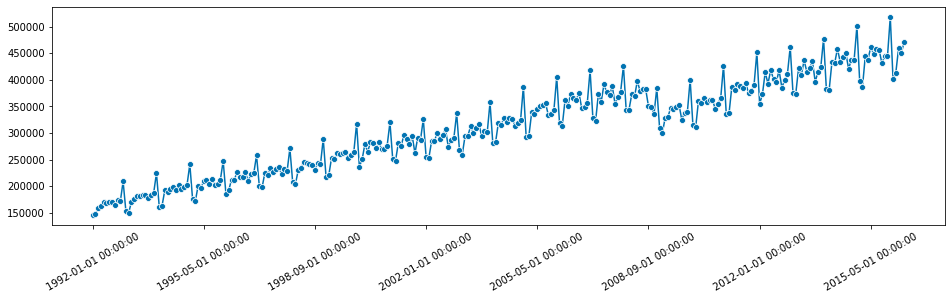

In [5]:
plot_series(df)
plt.xticks(rotation=30);

## how to use LOWESS to extract a trend from a time series.

### statsmodel implementation

* LOWESS (Locally Weighted Scatterplot Smoothing)

* A lowess function that outs smoothed estimates of endog at the given exog values from points (exog, endog)


### parameters 

* `endog` : 1-D numpy array<br>
    The y-values of the observed points
* `exog` : 1-D numpy array<br>
    The x-values of the observed points
* `frac` : float<br>
    Between 0 and 1. The fraction of the data used when estimating each y-value.
* `it` : int<br>
    The number of residual-based reweightings to perform.
* `delta` : float<br>
    Distance within which to use linear-interpolation instead of weighted regression.
* `xvals`: 1-D numpy array<br>
    Values of the exogenous variable at which to evaluate the regression. If supplied, cannot use delta.


Stats model requires the exog (X-values) to be neumeric. We cant pass the time-index as exog

if we provide `xvals` then the method return  fitted values only for specific x values


In [7]:
X = np.arange(len(df))
y = df['y']

result = lowess(endog=y, exog=X, frac=0.1, it=3)
result[:5]

array([[0.00000000e+00, 1.56224386e+05],
       [1.00000000e+00, 1.57578127e+05],
       [2.00000000e+00, 1.58916267e+05],
       [3.00000000e+00, 1.60244262e+05],
       [4.00000000e+00, 1.61568493e+05]])

The output has two columns 
* column 1 is the X-values themselves
* column 2 is the lowess smoothed estimates

Lets plot it

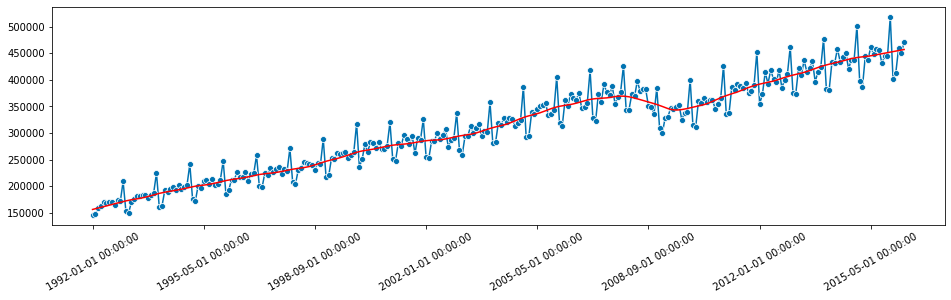

In [13]:
plot_series(df)
plt.xticks(rotation=30);
plt.plot(result[:,1], c='r');

### if we provide `xvals` then the method return  fitted values only for specific x values

In [48]:
X = np.arange(len(df))
y = df['y']

result = lowess(endog=y, exog=X, frac=0.1, it=3, xvals=X[-10:])
result[:5] # array is one-dimensional

array([448252.90369367, 449267.91660255, 450274.80510256, 451269.94808227,
       452253.92943984])

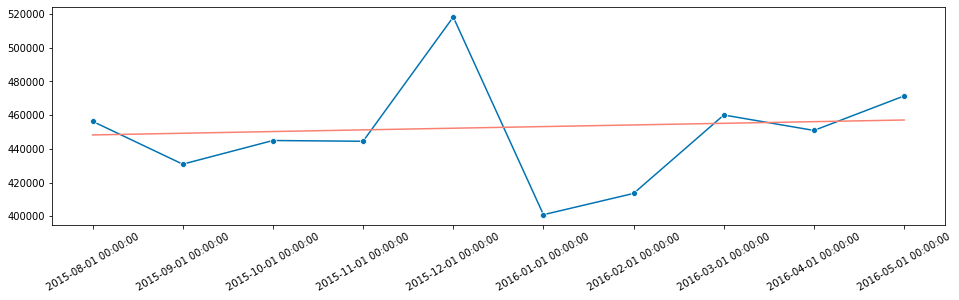

In [57]:
plot_series(y[-10:])
plt.plot(result, c='salmon');
plt.xticks(rotation=30);

## Exploring the frac parameter

#### The fraction of data to use in a window in LOWESS determines how smooth the fit is. Let's plot a few examples to illustrate this.

* if frac is too high we will over-smoothes
* if frac is too low we will under-smoothes

In [58]:
def lowess_estimates(X=None, y=None, frac=0.1, visualize=True, output_trend=False, title='', Xvals=None):
    X = X if X is not None else np.arange(len(df))
    y = y if y is not None else df['y']

    result = lowess(endog=y, exog=X, frac=frac, it=3, xvals=Xvals)

    if visualize:
        plot_series(df)
        plt.xticks(rotation=30);
        plt.plot(result[:,1], c='r');
        plt.title(f'LOWESS smoothed estimates -- frac={frac} {title}')
    
    if output_trend:
        return result[:,1] if Xvals is None else result

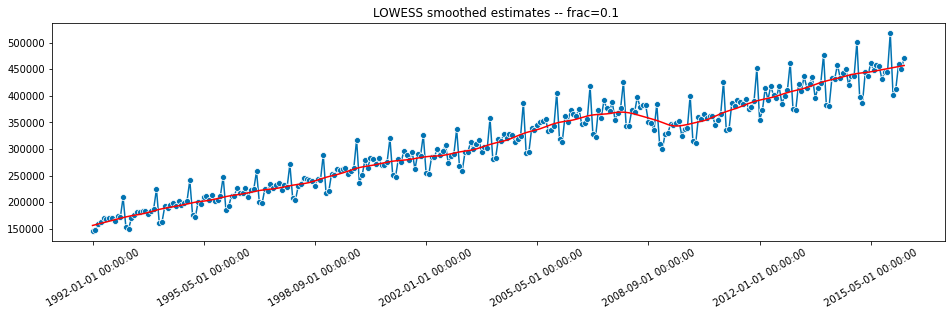

In [59]:
lowess_estimates()

### Over-smoothing

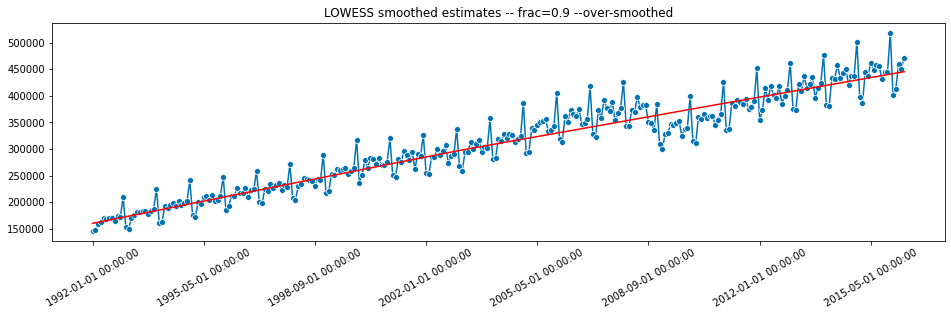

In [43]:
lowess_estimates(frac=0.9, title='--over-smoothed')

### Under-smoothing

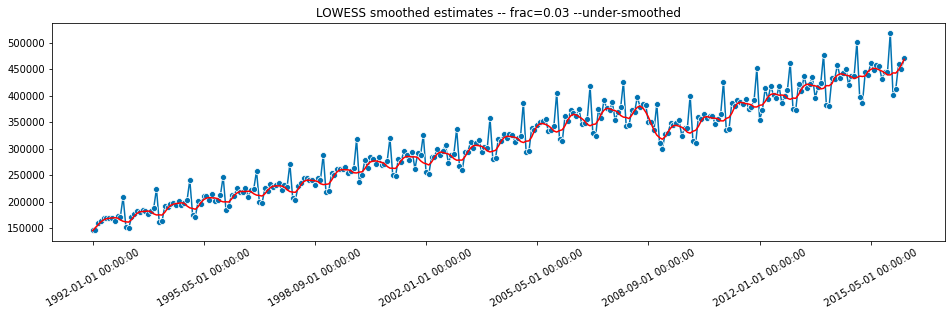

In [30]:
lowess_estimates(frac=0.03, title='--under-smoothed')

## How do we select the optimal value of `frac`

### Using K-Fold cross validation to select the `frac` parameter

In [64]:
X = np.arange(len(df))
y = df['y']

frac_performace = {}

rmse = lambda y_true, y_pred : np.sqrt(np.mean(np.square((y_true-y_pred))))

for f in np.arange(0.02, 1.02, 0.02):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics=[]
    for train_idx, test_idx in kfold.split(X, y):
        X_train, y_train = X[train_idx], y.iloc[train_idx]
        X_test, y_test = X[test_idx], y.iloc[test_idx]
        y_pred = lowess_estimates(X=X_train, y=y_train, Xvals=X_test, frac=f, visualize=False, output_trend=True)

        performance = rmse(y_test, y_pred)
        metrics.append(performance)
    
    mean_rmse = np.mean(metrics)
    frac_performace[f]=mean_rmse

## Visualize

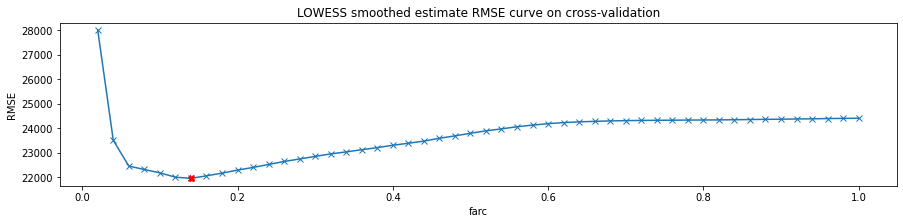

In [86]:
plt.figure(figsize=(15,3))
plt.plot(frac_performace.keys(), frac_performace.values(), marker='x')
plt.xlabel('farc')
plt.ylabel('RMSE')
plt.title('LOWESS smoothed estimate RMSE curve on cross-validation')

lowest = np.argmin(list(frac_performace.values()))
plt.plot(list(frac_performace.keys())[lowest], list(frac_performace.values())[lowest], marker='X', c='r');


In [84]:
optimal_frac = list(frac_performace.keys())[lowest]
print(f'frac for which RMSE is the lowest is {optimal_frac}')

frac for which RMSE is the lowest is 0.13999999999999999


### Lets use the optimal frac

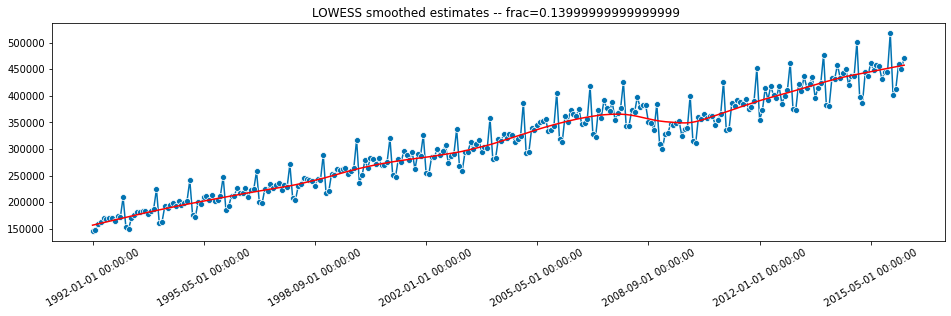

In [85]:
lowess_estimates(frac=optimal_frac)